In [109]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit as qk
import random

from generator import generateCliffordCircuit
# from execution.transpiler import transpileListToQiskitCircuit

In [96]:
def stringToQiskitSingleGate(gateString, qiskitCir, whichQubit):
    if gateString == 'I':
        qiskitCir.id(whichQubit)
    elif gateString == 'X':
        qiskitCir.x(whichQubit)
    elif gateString == 'Y':
        qiskitCir.y(whichQubit)
    elif gateString == 'Z':
        qiskitCir.z(whichQubit)
    elif gateString == 'H':
        qiskitCir.h(whichQubit)
    elif gateString == 'S':
        qiskitCir.s(whichQubit)
        
def transpileListToQiskitCircuit(cir):
    depth = len(cir)
    width = len(cir[0])
    qiskitCir = qk.QuantumCircuit(width)
    for d in range(width):
        if d % 2 == 0:
            for w in range(width):
                singleGate = cir[d][w]
                stringToQiskitSingleGate(singleGate, qiskitCir, w)
            if d != width - 1:
                qiskitCir.barrier()
        else:
            c = cir[d].index('CNOT_C')
            t = cir[d].index('CNOT_T')
            qiskitCir.cx(c, t)
            if d != width - 1:
                qiskitCir.barrier()
    return qiskitCir

In [98]:
width = 5 # num_qubits
depth = 5 # number of layers in the circuit (easy + hard)
singleGateSet = ['X', 'H', 'Z', 'I', 'S']
doubleGateSet = ['CNOT_C', 'CNOT_T']
twirlingGateSet = ['X','Y' 'Z', 'I']

circuit = generateCliffordCircuit(width, depth, singleGateSet, doubleGateSet)
qiskitCircuit = transpileListToQiskitCircuit(circuit)
print(circuit)
if depth < 10:
    print(qiskitCircuit)

[['I', 'H', 'I', 'X', 'I'], ['CNOT_T', 'I', 'I', 'CNOT_C', 'I'], ['H', 'S', 'Z', 'X', 'I'], ['CNOT_T', 'I', 'CNOT_C', 'I', 'I'], ['Z', 'S', 'X', 'S', 'X']]
     ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐
q_0: ┤ I ├─░─┤ X ├─░─┤ H ├─░─┤ X ├─░─┤ Z ├
     ├───┤ ░ └─┬─┘ ░ ├───┤ ░ └─┬─┘ ░ ├───┤
q_1: ┤ H ├─░───┼───░─┤ S ├─░───┼───░─┤ S ├
     ├───┤ ░   │   ░ ├───┤ ░   │   ░ ├───┤
q_2: ┤ I ├─░───┼───░─┤ Z ├─░───■───░─┤ X ├
     ├───┤ ░   │   ░ ├───┤ ░       ░ ├───┤
q_3: ┤ X ├─░───■───░─┤ X ├─░───────░─┤ S ├
     ├───┤ ░       ░ ├───┤ ░       ░ ├───┤
q_4: ┤ I ├─░───────░─┤ I ├─░───────░─┤ X ├
     └───┘ ░       ░ └───┘ ░       ░ └───┘


In [99]:
def Clifford_Permute(cliff,pauli):
    '''This function permutes the pauli operators according to the clifford group, so it computes 
    P' = C P C^T, where C is a clifford operator and P is a pauli operator.
    Inputs: cliff - A Qiskit Circuit, Clifford, or Gate object.
            pauli - A Qiskit Pauli object.
    Outputs: new_pauli - A Qiskit Pauli object.'''

    return pauli.evolve(cliff,frame="s")


In [95]:
Clifford_Permute(qiskitCircuit.data[3].operation, qk.quantum_info.Pauli('X'))

Pauli('Y')

In [80]:
me = qk.quantum_info.Pauli("Y"*width)
Clifford_Permute(qiskitCircuit,me)

Pauli('YYIYX')

In [103]:
def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield qk.QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

# for subcircuit in (split_circuit_by_barrier(qiskitCircuit)):
#     print(subcircuit)

In [141]:
def G_twirling(circuit):
    '''This function performs G-twirling on a circuit. It randomly chooses a Pauli from {X,Y,Z,I} and prepends it before a layer, then appends P'=CPC^T after the layer.}
    Inputs: circuit - A Qiskit Circuit object.
    Outputs: new_circuit - A Qiskit Circuit object.'''
    num_qubits = circuit.num_qubits
    new_circuit = qk.QuantumCircuit(num_qubits)
    for subcircuit in (split_circuit_by_barrier(new_circuit)):
        pauli = qk.quantum_info.Pauli(''.join(random.choice(["X","Y","Z","I"]) for _ in range(num_qubits)))
        new_circuit = new_circuit.compose(pauli.to_instruction(),qubits=range(num_qubits))
        new_circuit = new_circuit.compose(subcircuit,qubits=range(num_qubits))
        new_circuit = new_circuit.compose(Clifford_Permute(subcircuit,pauli).to_instruction(),qubits=range(num_qubits))

    return new_circuit


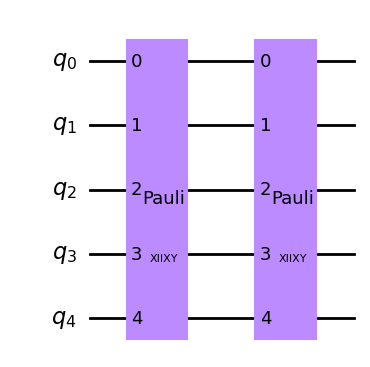

In [142]:
G_twirling(qiskitCircuit).draw(output='mpl')

In [132]:
pauli = qk.quantum_info.Pauli(''.join(random.choice(["X","Y","Z","I"]) for _ in range(5)))
c = qk.QuantumCircuit(5).compose(pauli.to_instruction())
c.draw()

┌───────────────┐
q_0: ┤0              ├
     │               │
q_1: ┤1              ├
     │               │
q_2: ┤2 Pauli(YXZYY) ├
     │               │
q_3: ┤3              ├
     │               │
q_4: ┤4              ├
     └───────────────┘